# Lab 1: Computer Vision Tutorial

## Introduction

*__Warning:__ The camera widget does not work on VS Code. Run this notebook on the browser!*

In this tutorial, you will learn the basics of *Computer Vision* (CV) through hands-on practice. We cover the following topics:

1. How to get image and video data in and out of Python.
2. How to do basic image manipulation.
3. How to perform *color thresholding* to detect the position of objects.
4. How to perform *face detection* using a Haar-Cascade classifier.

We will focus on *offline* processing, meaning we will first record a video using your webcam as a source, and then process it. The opposite, *online* processing, deals with real-time image manipulation. Both offline and online processing use the same techniques we will introduce here, with the only difference that online processig needs to run very fast.

For each topic, you will first get a small demo introducing the concepts, and then you will solve exercises using what you have learned.

First things first, import the libraries you will use throughout the tutorial.

In [2]:
from pathlib import Path

import cv2
import numpy as np
from imageio import v3 as iio

# For Visualization in Jupyter
import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, Image, Video

# Get images and video into Jupyter from your webcam
from ipywebrtc import CameraStream, ImageRecorder, VideoRecorder

# 1. I/O for Images

Our first task is to load and save images and videos. We will use two packages:

* [OpenCV](https://opencv.org/) (imported as `cv2` above) is a powerful CV library with many utilities. We will use it later for image transformations, and to add text to videos. It can load images through the function `cv2.imread()`, and videos through the class `cv2.VideoCapture`. However, its API is hard to use and tends to fail silently.
* [ImageIO](https://imageio.readthedocs.io/en/latest/) (imported as `iio` above) only does image input and output. Its API is much simpler: `iio.imread()` and `iio.imwrite()` handle all our I/O needs. It has more robust support for common formats like `mp4` video than OpenCV, and also supports more exotic formats.

### 1.1 Loading and Displaying Images with ImageIO

Load a local file (from the same directory as the notebook):

In [2]:
iio_image = iio.imread("logo.png")

ImageIO loads images as NumPy arrays with shape `(height, width, channels)`:

In [3]:
print(f"ImageIO: {type(iio_image)}")
print(f"ImageIO Shape: {iio_image.shape}")
print(f"ImageIO dType: {iio_image.dtype}")

ImageIO: <class 'numpy.ndarray'>
ImageIO Shape: (131, 518, 4)
ImageIO dType: uint8


This PNG has height 131px and width 518px. It stores its pixels as `uint8` (unsigned 8-bit integers, values 0 to 255) and has 4 *channels*: Red, Green, Blue, Alpha (RGBA).

[Pyplot](https://matplotlib.org/stable/index.html) (imported as `plt` above) is commonly used to plot mathematical functions and data points, but can also be used to display images:

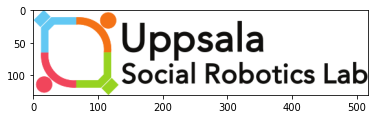

In [4]:
plt.imshow(iio_image)

### 1.2 Loading and Displaying Images with OpenCV

Same local file, same signature:

In [5]:
cv2_image = cv2.imread("logo.png")

OpenCV also loads the image as a NumPy array with shape `(height, width, channels)`:

In [6]:
print(f"OpenCV: {type(cv2_image)}")
print(f"OpenCV Shape: {cv2_image.shape}")
print(f"OpenCV dType: {cv2_image.dtype}")

OpenCV: <class 'numpy.ndarray'>
OpenCV Shape: (131, 518, 3)
OpenCV dType: uint8


Note that OpenCV has converted the PNG from RGBA (image with transparency) to BGR (only color channels). Using Pyplot again:

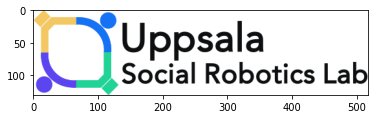

In [8]:
plt.imshow(cv2_image)

**What went wrong?** As we said, OpenCV uses BGR: Blue, Green, Red. Pyplot (like most modern libraries) expects Red, Green, Blue. The colors are out of order! We have to reorder before displaying:

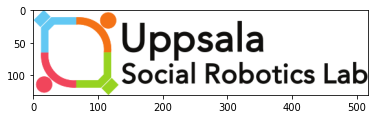

In [10]:
cv2_image_corrected = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2_image_corrected)
plt.show()

So far we have seen colors specified as RGBA, BGR and RGB, with 8-bit unsigned integers in each channel. Many other variants exist: grayscale (1 color channel), color palettes (1 *index* channel), using floating point numbers, using less bits for some color channels... it gets complicated.

Each one of these specifications is a [**color space**](https://en.wikipedia.org/wiki/Color_space). We will use this expression from now on to indicate which interpretation of the channels we are using.

### 1.3 Advanced ImageIO for Fun and Profit

Another limitation for OpenCV is that it can only load data from files in your system, given as path strings like we did above. ImageIO happily reads images from all kinds of sources:

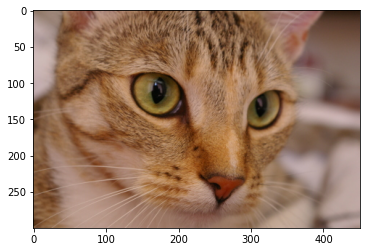

In [12]:
# From a remote URL:
web_image = iio.imread("https://i.imgur.com/FV6x1vX.jpg")

# From a Python file object:
with open("logo.png", "rb") as file_object:
    obj_image = iio.imread(file_object)

# From the ImageIO "standard image" collection:
standard_image = iio.imread("imageio:chelsea.png")
plt.imshow(standard_image)

Here the function [`open()`](https://docs.python.org/3/library/functions.html#open) is used to work with files. It takes two parameters: the path to the file, and the *mode*. Here, we use `"rb"` to **r**ead a **b**inary file. Later we will use `"wb"` to **w**rite a **b**inary file. The `with ... as ... :` idiom takes care of opening and closing the file for us.

Further, you can find the full list of supported sources [in the docs](https://imageio.readthedocs.io/en/latest/getting_started/requests.html). There is also a list of [standard images](https://imageio.readthedocs.io/en/latest/getting_started/standardimages.html) you can use for prototyping and examples.

By default, `iio.imread()` respects the file's color space when loading an image. You can request a different one by setting the `mode` parameter. For example, to load the PNG without transparency:

In [11]:
image = iio.imread("logo.png", mode="RGB")

### 1.4 Displaying an Image Natively in Jupyter

Displaying an image with Pyplot is a nice single function call, but it adds axes and margins that are hard to get rid of. There is a native Jupyter alternative: the class `IPython.display.Image`. We can pass a local file path as a string:

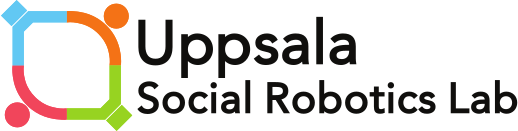

In [12]:
Image("logo.png")

We can also pass an image from memory. `Image` does not know how to read NumPy arrays, so we have to convert it to a PNG *byte string* using one of the output formats in `iio.imwrite()`:

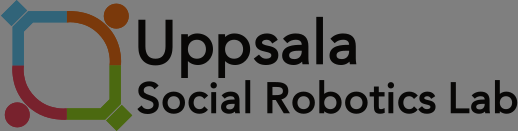

In [13]:
image = iio.imread("logo.png", mode="RGB")
image = image // 2 # image is a NumPy array, we can process it with math.

display_image = iio.imwrite("<bytes>", image, plugin="pillow", format="PNG")
Image(display_image)

A byte string is just a variable-length sequence of bytes. We will use them often in the rest of the lab.

### 1.5 Loading Images from a Webcam in Jupyter

To load images from a webcam you have several options. The first is to use a Jupyter widget, which will access the webcam through your browser. For this to work you have to grant jupyter the permission to access your webcam.

In [14]:
camera = CameraStream(constraints=
                      {"facing_mode": "user",
                       "audio": False,
                       "video": { "width": 640, "height": 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [15]:
recorder = ImageRecorder(stream=camera)
recorder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

Once you are happy with the snapshot, make sure to close the webcam.

In [28]:
camera.close()

A snapshot is a byte string in PNG format. We can write it to disk using Python's `open()`:

In [23]:
with open("snapshot.png", "wb") as file:
    file.write(recorder.image.value)

We can then display it directly:

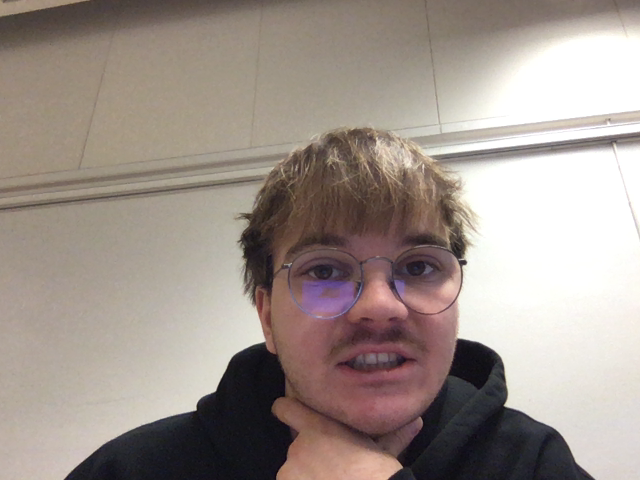

In [26]:
Image("snapshot.png")

Or we can use `iio.imread()` to convert the byte string to a NumPy array:

In [25]:
snapshot = iio.imread(recorder.image.value, mode="RGB")

Another option is to use `iio.imread()` directly. If you only have one device, pass `"<video0>"` as the source. If you have multiple devices, you will have to try `"<video0>"`, `"<video1>"`, `"<video2>"`...

This method does not come with a nice UI like `ImageRecorder`. It will take the snapshot immediately.

In [27]:
snapshot = iio.imread("<video0>", index=0)

ImportError: To use the imageio ffmpeg plugin you need to 'pip install imageio-ffmpeg'

### Exercise 1

Display all the (single) images above that have not been visualized above:

- The web URL image.
- The ImageIO standard image.
- the file object image.
- the webcam snapshot.

You can choose to display the image using either an image widget or matplotlib.

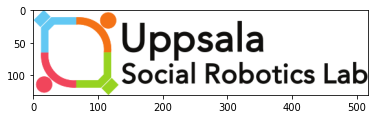

In [33]:
# Will not display web URL due to SSL errors

# ImageIO standard
standardimg = iio.imread("imageio:chelsea.png")
plt.imshow(standardimg)

with open("logo.png", "rb") as file_object:
    objimg = iio.imread(file_object)
plt.imshow(objimg)


### 1.6 Writing Images

Just like `iio.imread()` reads in various formats from various sources, `iio.imwrite()` writes images in various formats to various targets. If possible, ImageIO will deduce the format to use from the target's extension. If that is impossible, e.g., because the target doesn't have a file type, you can specify the format manually.

In [21]:
# Save the snapshot as a JPG file.
iio.imwrite("snapshot.jpg", snapshot)

# Save he web image as a PNG file.
web_image = iio.imread("https://i.imgur.com/FV6x1vX.jpg")
iio.imwrite("web_image.png", web_image)

# Save the screenshot as a PNG byte string.
bytes_string = iio.imwrite("<bytes>", snapshot, plugin="pillow", format="PNG")

NameError: name 'snapshot' is not defined

## 2. I/O for Video

### 2.1 Recording Video from the Webcam

In essence, a video is a sequence of images that play in quick succession. As such, recording video works very similarly to reading images.

In [4]:
camera = CameraStream(constraints=
                      {"facing_mode": "user",
                       "audio": False,
                       "video": { "width": 640, "height": 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [5]:
recorder = VideoRecorder(stream=camera)
recorder

VideoRecorder(stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, …

In [6]:
camera.close()

Reviewing the widgets we used for image capture:
- `ImageRecorder` takes a picture and encodes it as a PNG byte string.
- `VideoRecorder` takes a video and encodes it as a WEBM byte string.

### 2.2 Saving and Displaying Video

To load and display the video, one option is to write to a file, and load the file.

In [8]:
with open("webcam_video.webm", "wb") as video_file:
    video_file.write(recorder.video.value)

`iio.imread()` cannot currently read WEBM byte strings, but it can read WEBM from disk:

In [9]:
frames = iio.imread("webcam_video.webm")
frames.shape, frames.dtype

((155, 480, 640, 3), dtype('uint8'))

Just like images, videos get loaded as NumPy arrays. The shape of the array is `(time, height, width, channels)`. We can see there are 3 color channels with 8-bit integers. The video has been loaded as RGB.

Just like `Image`, `IPython.display.Video` lets us display videos from file natively in Jupyter.

In [10]:
Video("webcam_video.webm")

If we want to avoid writing to disk, another option is `iio.imopen()`:

In [23]:
with iio.imopen(recorder.video.value, "r", format="ffmpeg") as video_file:
    frames = np.array(video_file.read())
frames.shape

(155, 480, 640, 3)

To save a video in NumPy format directly to file, we can use `iio.imwrite()`.

In [26]:
iio.imwrite("example1.mp4", frames, fps=30)

ValueError: Image must have 1, 2, 3 or 4 channels

In [27]:
Video("example1.mp4")

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

### Exercise 2

Create a new video and display it using the video widget.

In [32]:
camera = CameraStream(constraints=
                      {"facing_mode": "user",
                       "audio": False,
                       "video": { "width": 640, "height": 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [33]:
recorder = VideoRecorder(stream=camera)
recorder

VideoRecorder(stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, …

In [34]:
camera.close()

In [35]:
with open("webcam_video2.webm", "wb") as video_file:
    video_file.write(recorder.video.value)

In [36]:
Video("webcam_video2.webm")

### Exercise 3

Load the video you created above, split it frame by frame, and save the frames to disk. 

*__Note:__ Since a video will have a lot of frames, it is advisable to store them in a sub-folder. You can create one using Jupyter's line magic. For example, to create the directory `imgs` you would do: `!mkdir imgs`.*

In [104]:
with iio.imopen("webcam_video2.webm", "r", format="ffmpeg") as video_file:
    frames = video_file.read()

for i in range(len(frames)-1): 
    if i < 10:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/aframe"+str(i)+".jpg", curr_frame)
    elif i < 20 and i >= 10:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/bframe"+str(i)+".jpg", curr_frame)
    elif i < 30 and i >= 20:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/cframe"+str(i)+".jpg", curr_frame)
    elif i < 40 and i >= 30:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/dframe"+str(i)+".jpg", curr_frame)
    elif i < 50 and i >= 40:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/eframe"+str(i)+".jpg", curr_frame)
    elif i < 60 and i >= 50:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/fframe"+str(i)+".jpg", curr_frame)
    elif i < 70 and i >= 60:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/gframe"+str(i)+".jpg", curr_frame)
    elif i < 80 and i >= 70:
        curr_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("./imgs/hframe"+str(i)+".jpg", curr_frame)

### Exercise 4

Using the batch of images you created in Exercise 3, convert the images back to a video. Afterwards, inspect the created video and verify that it matches the original input video.

*__Hint:__ You can iterate over the files in a folder using the* `Path` *class. [Here is the documentation](https://docs.python.org/3/library/pathlib.html#basic-use).*

In [105]:
path = Path('./imgs')

img_arr = []
str_arr = []
last_frame = ''
for frame in path.iterdir():
    if str(frame) != 'imgs/.ipynb_checkpoints':
        str_arr.append(str(frame))
       
str_arr.sort()
print(str_arr)

for frame in str_arr:
    img = cv2.imread(str(frame))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

output = cv2.VideoWriter('from_frames.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    output.write(img_array[i])
output.release()

['imgs/aframe0.jpg', 'imgs/aframe1.jpg', 'imgs/aframe2.jpg', 'imgs/aframe3.jpg', 'imgs/aframe4.jpg', 'imgs/aframe5.jpg', 'imgs/aframe6.jpg', 'imgs/aframe7.jpg', 'imgs/aframe8.jpg', 'imgs/aframe9.jpg', 'imgs/bframe10.jpg', 'imgs/bframe11.jpg', 'imgs/bframe12.jpg', 'imgs/bframe13.jpg', 'imgs/bframe14.jpg', 'imgs/bframe15.jpg', 'imgs/bframe16.jpg', 'imgs/bframe17.jpg', 'imgs/bframe18.jpg', 'imgs/bframe19.jpg', 'imgs/cframe20.jpg', 'imgs/cframe21.jpg', 'imgs/cframe22.jpg', 'imgs/cframe23.jpg', 'imgs/cframe24.jpg', 'imgs/cframe25.jpg', 'imgs/cframe26.jpg', 'imgs/cframe27.jpg', 'imgs/cframe28.jpg', 'imgs/cframe29.jpg', 'imgs/dframe30.jpg', 'imgs/dframe31.jpg', 'imgs/dframe32.jpg', 'imgs/dframe33.jpg', 'imgs/dframe34.jpg', 'imgs/dframe35.jpg', 'imgs/dframe36.jpg', 'imgs/dframe37.jpg', 'imgs/dframe38.jpg', 'imgs/dframe39.jpg', 'imgs/eframe40.jpg', 'imgs/eframe41.jpg', 'imgs/eframe42.jpg', 'imgs/eframe43.jpg', 'imgs/eframe44.jpg', 'imgs/eframe45.jpg', 'imgs/eframe46.jpg', 'imgs/eframe47.jpg', '

## 3. Basic Image Manipulation with OpenCV

In section 1, you already saw some color spaces: RGB, RGBA, and BGR. Now, you will learn how to convert images into grayscale, and what the HSV color space is about.

Let's start by loading a standard image.

(512, 512, 3)


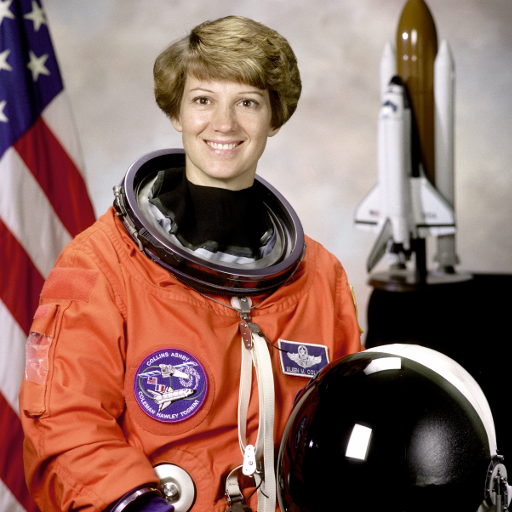

In [106]:
image = iio.imread("imageio:astronaut.png")

display_image = iio.imwrite("<bytes>", image, plugin="pillow", format="PNG", mode="RGB")
print(image.shape)
Image(display_image)

### 3.1 Convert an RGB image to Grayscale

Suppose we want to convert an image to grayscale. Since the image is just a NumPy array, it is tempting to just take the mean of Red, Green, and Blue:

[NumPy conversion] image shape: (512, 512)


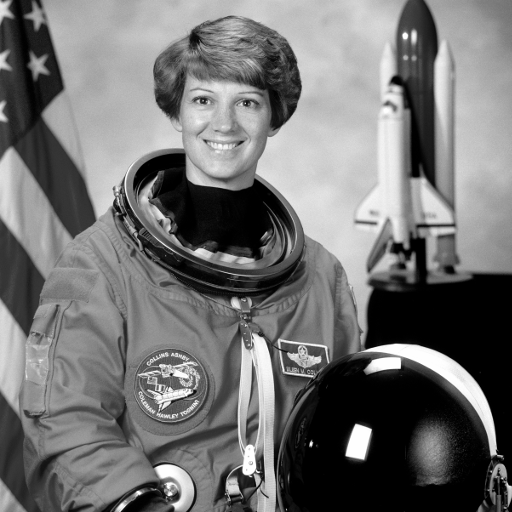

In [107]:
image_gray_np = np.mean(image, axis=2).astype(np.uint8)

display_image = iio.imwrite("<bytes>", image_gray_np, plugin="pillow", format="PNG", mode="L")
print(f"[NumPy conversion] image shape: {image_gray_np.shape}")
Image(display_image)

This is not bad, but [it is not perceptually accurate](https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale). And it only gets worse for other color spaces! Thankfully, `cv2` has the tools we need for *precise* color conversion.

To convert between color spaces, use `cv2.cvtColor()`. It takes the image to transform, and the conversion to perform as a constant `cv2.COLOR_<ORIGINAL>2<FINAL>`. For example, `cv2.COLOR_BGR2RGB` for BGR -> RGB, or `cv2.COLOR_RGB2GRAY` for RGB -> grayscale.

[CV2 conversion] image shape: (512, 512)


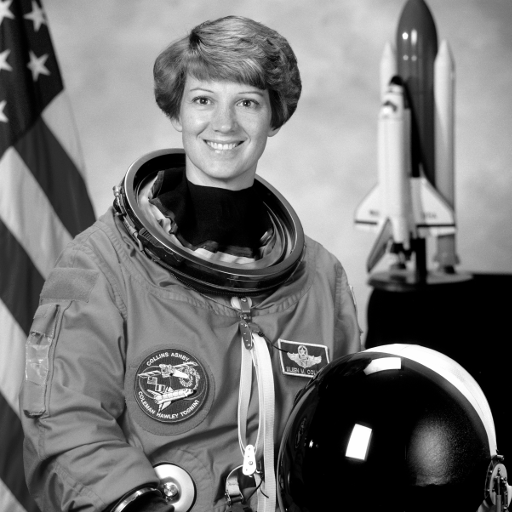

In [108]:
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

display_image = iio.imwrite("<bytes>", image_gray, plugin="pillow", format="PNG", mode="L")
print(f"[CV2 conversion] image shape: {image_gray.shape}")
Image(display_image)

Notice that both approaches have reduced the shape from `(height, width, channels)` (called a *rank 3 tensor* because of the 3 indices) to `(height, width)` (a *rank 2 tensor*, a matrix). A `channels` index is not needed, since grayscale only has one channel (often called *luminance*, hence the parameter `mode="L"`).

### 3.2 Convert RGB into HSV

The RGB color space is useful because [that's how our eyes, our cameras and our screens work](https://en.wikipedia.org/wiki/RGB_color_model). However, it's often useful to think of colors as a brightness, a saturation and a location in the [color wheel](https://en.wikipedia.org/wiki/Color_wheel) instead, like we would do if we were discussing a choice of shirt or what color we want for our bedroom wall.

There are several color spaces that try to capture this idea. Among them, we will focus on the Hue, Saturation, Value (HSV) model. Hue is the position in the color wheel (from red to purple and circling around), Saturation is the intensity of the color (from grayscale to full color), and Value is the brightness of the color (from black to "fully intense"). In other color systems ([CIELAB, for example](https://en.wikipedia.org/wiki/CIELAB_color_space)), full "brightness" means white, but note that in HSV, `V=100%` is only white if `S=0%`.

Again, this is a single call in OpenCV:

In [109]:
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

display_image = iio.imwrite("<bytes>", image_hsv, plugin="pillow", format="PNG", mode="RGB")
widgets.Image(value=display_image)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x02\x00\x08\x02\x00\x00\x00{\x1aC\xa…

You probably were not expecting this psychedelic horror display. The reason is that we are violating the assumptions for `iio.imwrite()`. We specified `mode="RGB"`, and passed in HSV, so the channels are once again mixed up. ImageIO supports the HSV color space, but the PNG format does not. Hence, we are stuck looking at the image using false colors.

### 3.3 Stacking Images

Sometimes, we need a color image with shape `(height, width, channels)`, but we have a grayscale image with shape `(height, width)`. Or we want to paste images together, side by side. We can solve these issues through NumPy's *stacking* calls:

In [110]:
# Stack 3 copies of a grayscale image into a "color" image:
image_gray_stacked = np.stack([image_gray] * 3, axis = 2)

# Stack up HSV, original and (stacked) grayscale images side by side:
stacked = np.hstack([image_hsv, image, image_gray_stacked])

# Display the combined image:
display_image = iio.imwrite("<bytes>", stacked, plugin="pillow", format="PNG", mode="RGB")
widgets.Image(value=display_image)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\x00\x00\x00\x02\x00\x08\x02\x00\x00\x00\xcb\xc30…

### 3.4 Displaying Text on an Image

OpenCV allows you to add text to an image. The format is verbose, but very handy:

*__Note:__* `cv2.putText()` *modifies the image you pass in, so make a copy first!*

In [111]:
image_hsv_copied = image_hsv.copy()

text_string = "HSV"
position = (5, 50) # Pixels from the image's top left to the text's bottom left.
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 2
font_color = (255, 255, 255) # Remember: BGR.
font_thickness = 4

cv2.putText(image_hsv_copied, text_string, position, font, font_size, font_color, font_thickness)

#display the image
display_image = iio.imwrite("<bytes>", image_hsv_copied, plugin="pillow", format="PNG", mode="RGB")
widgets.Image(value=display_image)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x02\x00\x08\x02\x00\x00\x00{\x1aC\xa…

### Exercise 5

Load the video that you took in the first part of this tutorial, and convert it to grayscale. You can choose to save it as a file, or to display the gray frames directly. Either way, show your result by displaying it below.

### Exercise 6

Record a video that is at least 10 seconds long. Then, use this video and place a label in the top right corner denoting that it is in BGR format. After 5 seconds convert the remaining video into HSV and change the label to indicate that the video is now in HSV.

### Exercise 7

Write a piece of code that 

1. loads the video you just recorded.
2. converts every frame into both grayscale and HSV.
3. stacks the 3 images side by side in order HSV-original-grayscale.
4. writes the "stacked" video to a file.

## 4. Object Detection Through Color Thresholding

*Object detection* consists in finding *if* and *where* a certain type of object appears in a picture or video. This is a hard problem, and current state-of-the-art solutions involve Deep Neural Networks trained on millions of images. Luckily, sometimes all we need is some clever use of color. *Color thresholding* consists in finding objects by specifying a valid *range of colors* that the object might take, and discarding the rest of the pixels.

Let's try it out! First, you will need an image that contains an object to detect. The example image here is from the biomedical field, because there are less colors overall, but you can easily apply this to any other image.

*__Sidenote:__ Immunohistochemistry is the process of using antibodies to color/stain specific parts of a tissue sample (cell membrane, DNA, ...), so that they can be distinguished later. Among other things, it is used in cancer research and cancer diagnosis to differentiate cancer cells from normal cells.*

In [ ]:
bio_image = iio.imread("imageio:immunohistochemistry.png")
display_image = iio.imwrite("<bytes>", bio_image, plugin="pillow", format="PNG", mode="RGB")
widgets.Image(value=display_image)

You can filter pixels by their color values using `cv2.inRange`. For each pixel, the command checks all channels:
```
lower[0] < pixel[0] < upper[0] and lower[1] < pixel[1] < upper[1] and ...
```
It returns a *mask*: a rank-2 tensor of shape `(height, width)`, with 1's for the pixels that satisfy the above condition, and 0's for the pixels where at least one channel is outside the specified range. You can use this mask to remove parts of the image that you are not interested in (e.g., set them to black).

In [ ]:
disp = widgets.Image()

def thresholdRGB(img, lower, upper):
    mask = cv2.inRange(img, np.array(lower), np.array(upper))
    masked = cv2.bitwise_and(img, img, mask = mask)
    display_image = iio.imwrite("<bytes>", masked, plugin="pillow", format="PNG")
    disp.value = display_image

To explore this, you can use Jupyter's `interact()` function. It allows you to specify function parameters dynamically using sliders. You can use it to set the upper and lower filter values interactively. Try moving the sliders around and see if you can isolate the brown-ish objects (FHL2 protein).

In [ ]:
def wrapperRGB(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b):
    lower = [lower_r, lower_g, lower_b]
    upper = [upper_r, upper_g, upper_b]
    thresholdRGB(bio_image, lower, upper)
    display(lower, upper)

widgets.interact(wrapperRGB, 
                 lower_r=widgets.IntSlider(min=0, max=255, step=1, value=0), 
                 lower_g=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 lower_b=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 upper_r=widgets.IntSlider(min=0, max=255, step=1, value=255),
                 upper_g=widgets.IntSlider(min=0, max=255, step=1, value=255), 
                 upper_b=widgets.IntSlider(min=0, max=255, step=1, value=255))

display(disp)

While this is already quite potent, you may have noticed that there are still a lot of artifacts. I.e., there are a lot of small objects that the thresholding doesn't remove, and we can't get rid of them without also removing parts of the objects we are interested in.

To make the detection more robust, it is common to use the HSV colorspace that you encountered earlier. Because HSV projects hue onto a single channel it is much easier to select the color we want. Additionally, this improves robustness towards color changes induced by changes in illumination of an object.

Let's look at the difference in code, and explore it similarly to what we did previously.

In [ ]:
disp = widgets.Image()

def thresholdHSV(img, lower, upper):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    
    mask = cv2.inRange(img_hsv, np.array(lower), np.array(upper))
    masked = cv2.bitwise_and(img, img, mask = mask)
    
    display_image = cv2.imencode('.png', cv2.cvtColor(masked, cv2.COLOR_RGB2BGR))[1].tobytes()
    disp.value = display_image

In [ ]:
def wrapperHSV(lower_H, lower_S, lower_V, upper_H, upper_S, upper_V):
    lower = [lower_H, lower_S, lower_V]
    upper = [upper_H, upper_S, upper_V]
    thresholdHSV(bio_image, lower, upper)
    display(lower, upper)

widgets.interact(wrapperHSV, 
                 lower_H=widgets.IntSlider(min=0, max=255, step=1, value=0), 
                 lower_S=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 lower_V=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 upper_H=widgets.IntSlider(min=0, max=255, step=1, value=255),
                 upper_S=widgets.IntSlider(min=0, max=255, step=1, value=255), 
                 upper_V=widgets.IntSlider(min=0, max=255, step=1, value=255))

disp

To convince ourselves that this works on arbitrary objects, let's try this again, but this time on a different image. Grab a single color object (banana, pen, ...) and take a snapshot of it. Then, move the sliders until the image only contains the object in question.

In [ ]:
camera = CameraStream(constraints=
                      {"facing_mode": "user",
                       "audio": False,
                       "video": { "width": 640, "height": 480 }
                       })
camera

In [ ]:
recorder = ImageRecorder(stream=camera)
recorder

In [ ]:
camera.close()

In [ ]:
snapshot = iio.imread(recorder.image.value, mode="RGB")

In [ ]:
def wrapperHSV(lower_H, lower_S, lower_V, upper_H, upper_S, upper_V):
    lower = [lower_H, lower_S, lower_V]
    upper = [upper_H, upper_S, upper_V]
    thresholdHSV(snapshot, lower, upper)
    display(lower, upper)

widgets.interact(wrapperHSV, 
                 lower_H=widgets.IntSlider(min=0, max=255, step=1, value=0), 
                 lower_S=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 lower_V=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 upper_H=widgets.IntSlider(min=0, max=255, step=1, value=255),
                 upper_S=widgets.IntSlider(min=0, max=255, step=1, value=255), 
                 upper_V=widgets.IntSlider(min=0, max=255, step=1, value=255))

disp

Detecting the pixels that correspond to an object is nice. However, we usually want to do more than just know which pixels are part of the object. This is where contours come in handy. 

A contour is a line that moves along pixels of equal intensity (same value). In colored images it can be hard to specify what equal value means, so we typically consider grayscale images for this type of analysis. In the case of a binary image like the mask, contour analysis performs similar to connected component analysis. `cv2.findContours` is the command that will perform this analysis for you, and the usage is shown below.

After you computed the contours in the image, you may want to know where the detected shape is located at. For this you can compute the [image moments](https://en.wikipedia.org/wiki/Image_moment) of the detected shape. Moment is a term that comes from Physics, and is a measure of inertia of an object under force. We assume that the shape we detected is an object that has a fixed amount of mass located at each pixel. From that, we compute the different moments an object of that shape and mass distribution would have. With this trick, it is possible to compute the center of mass of an object (as well as area, orientation, ...).

In the example below we compute the center of mass, and then put a dot there and label it as center. You can play around with the image again, and see what it does.

In [ ]:
disp = widgets.Image()

def thresholdContours(img, lower, upper):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    
    mask = cv2.inRange(img_hsv, np.array(lower), np.array(upper))
    masked = cv2.bitwise_and(img, img, mask = mask)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(masked, contours, -1, (0, 0, 255), 2)
    
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue

        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(masked, (cX, cY), 7, (255, 255, 255), -1)
        cv2.putText(masked, "center", (cX - 20, cY - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    display_image = cv2.imencode('.png', cv2.cvtColor(masked, cv2.COLOR_RGB2BGR))[1].tobytes()
    disp.value = display_image

In [ ]:
def wrapperContours(lower_H, lower_S, lower_V, upper_H, upper_S, upper_V):
    lower = [lower_H, lower_S, lower_V]
    upper = [upper_H, upper_S, upper_V]
    thresholdContours(snapshot, lower, upper)
    display(lower, upper)

widgets.interact(wrapperContours, 
                 lower_H=widgets.IntSlider(min=0, max=255, step=1, value=0), 
                 lower_S=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 lower_V=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 upper_H=widgets.IntSlider(min=0, max=255, step=1, value=255),
                 upper_S=widgets.IntSlider(min=0, max=255, step=1, value=255), 
                 upper_V=widgets.IntSlider(min=0, max=255, step=1, value=255))

disp

As you can see, the algorithm picks up some artifacts and treats them as objects, too. How to solve this depends on the concrete scenario. In this case we can assume that artifacts are small with respect to the desired object, and hence all but the largest object can be discarded,

In [ ]:
disp = widgets.Image()

def thresholdBestContour(img, lower, upper):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    
    mask = cv2.inRange(img_hsv, np.array(lower), np.array(upper))
    masked = img.copy() #cv2.bitwise_and(img, img, mask = mask)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    max_idx = 0
    max_val = 0
    for idx, c in enumerate(contours):
        if cv2.contourArea(c) > max_val:
            max_idx = idx
            max_val = cv2.contourArea(c)

    cv2.drawContours(masked, contours[max_idx], -1, (0, 0, 255), 2)
    M = cv2.moments(contours[max_idx])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv2.circle(masked, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(masked, "center", (cX - 20, cY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    display_image = cv2.imencode('.png', cv2.cvtColor(masked, cv2.COLOR_RGB2BGR))[1].tobytes()
    disp.value = display_image

In [ ]:
def wrapperBestContour(lower_H, lower_S, lower_V, upper_H, upper_S, upper_V):
    lower = [lower_H, lower_S, lower_V]
    upper = [upper_H, upper_S, upper_V]
    thresholdBestContour(snapshot, lower, upper)
    display(lower, upper)

widgets.interact(wrapperBestContour, 
                 lower_H=widgets.IntSlider(min=0, max=255, step=1, value=0), 
                 lower_S=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 lower_V=widgets.IntSlider(min=0, max=255, step=1, value=0),
                 upper_H=widgets.IntSlider(min=0, max=255, step=1, value=255),
                 upper_S=widgets.IntSlider(min=0, max=255, step=1, value=255), 
                 upper_V=widgets.IntSlider(min=0, max=255, step=1, value=255))

disp

### Exercise 8

Record a video where you move the object you used for the color thresholding around in the scene. Then, using the threshold values you estimated when experimenting with above sliders, write a snippet that will read in a video file, and perform the following steps:

1. convert the video into HSV
3. performs color thresholding on the HSV images
4. estimates the position of the object based on the HSV image
5. displays a circle at the estimated center of mass of the object
6. stacks the original image and the thresholded image horizontally
7. labels each image
8. creates a video of the frames

Your output should look somewhat similar to the example video below.

## 4. Face Detection in OpenCV

As the final topic of this lab, you will look into face detection using Haar cascades; one of the classic methods to detect faces. It is computationally lightweight, and often used as the first step in computer vision pipelines that process faces.

Although deep learning is definitely on the rise, and will undoubtedly replace Haar cascades at some point in the future, there are still some limitations when it comes to running deep networks in real-time (25 FPS and more), or on embedded devices such as your smartphone. Hence, it is good to know about both approaches.

![Some example Haar Features](https://i.pinimg.com/originals/1d/ce/fc/1dcefc0ea496c458cf73cc6721c055b4.jpg)

So what are Haar cascades? A [Haar cascade](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) is a combination of two things: (1) a set of [Haar features](https://en.wikipedia.org/wiki/Haar-like_feature), and (2) a *cascade classifier*. 

1. A Haar feature is a function that computes a real number from an image. The image above shows a visualization of some example Haar features. Each Haar feature is computed by adding all the pixel values of the original image that are covered by the white region, and subtracting all the pixel values that are covered by the black region. This results in a single real number that roughly measures the "contrast" between black and white regions. If you use a whole set of these "contrast masks" on an image, you can create a *feature vector*, a representation of the image as a (small) collection of numbers.
2. A classifier is a function that assigns a label (in this case, "face" or "not face") to a set of features (in this case, the Haar feature set). A *cascade* classifier is made by combining several smaller classifiers. The first (quickest and least exact) may take only one or very few features as input. If it succeeds, we proceed to the second classifier, which takes a slightly bigger subset of features, and is a bit more precise. If it succeeds, we proceed to the third, and so on. If we *cascade* through all the classifiers successfully, a match is found. This "chain of command" allows us to be quick at discarding images that are not faces, but still dedicate extra computation to verify the correct cases.

A Haar cascade detects the position of a face using a sliding window. That is, it takes the input image, chops it up into many small parts, and classifies each part into either being a face or not being a face. The majority of these chunks will not be faces. This is what makes Haar cascades so fast, since they are able to reject these regions quickly without spending too much computational resources on them.

In OpenCV you can do all of this with a single function call: `cv2.CascadeClassifier.detectMultiScale`. You will have to supply it with a set of features to use, and an image to classify. Fortunately, OpenCV provides a sample set of features, and you can find it in the folder where this notebook is located. First, take a picture to detect a face in.

In [5]:
image = iio.imread("imageio:astronaut.png")

Next, create the classifier:

In [6]:
face_cascade = cv2.CascadeClassifier('frontal_face_features.xml')

It takes as input a grayscale image, and outputs a list of bounding boxes (rectangles) that contain faces.

In [7]:
snapshot_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(snapshot_gray)

All that is left is to draw these rectangles onto the image to visualize the classification.

In [8]:
detection = image.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(detection, (x, y), (x+w, y+h), (255, 0, 0), 2)

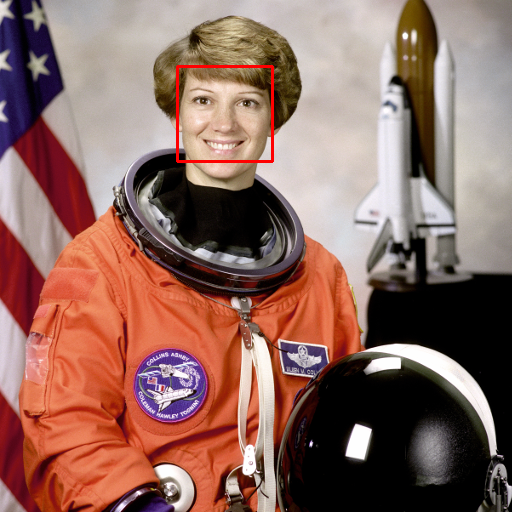

In [9]:
display_image = iio.imwrite("<bytes>", detection, plugin="pillow", format="PNG")
Image(display_image)

### Exercise 9

Write a pice of code that will load a video and that, for each frame, (1) performs face detection, and (2) draws the bounding box of the detection.

*__Note:__ You can use the video capture at* `recorder.video.value`.

### Exercise 10 (Bonus)

*__Note:__ For this exercise, we will only provide the keywords you need to search for, instead of example snippets for each step. You will eventually need to check online resources (e.g, the official documentation), so this is a good opportunity to practice.*

Using the code you have written above, replace the rectangle that visualizes the detection with an image that is shown on top of a face (for example, an emoji). You will need the following changes:

1. Choose a PNG image with transparency to use as a face substitute.
2. Load the image as an appropriate format (RGBA).
3. Split the loaded image into the RGB part (normal image) and alpha channel (mask).
4. Resize the image and mask to fit the region where a face was detected (using `cv2.resize()`).
5. Use the mask to perform `alpha blending` between the image and the frame.

*__Hint__: If you copy code from above examples, remember to remove the code that draws a red border around the face!*